# Chapter 4. Machine Learning for Molecules

**What is a Molecule?**

*Covalent Bond:*

* A molecule is a set of atoms joined by covalent bonds. 
* Covalent bonds invovle sharing electrons between two atoms. 
* Covalent bonds tend to be very stable. 

*Non-covalent Bond*: 

* Example: hydrogen bond
* Since they are not as strong as covalent bonds, they are more ephemeral, constantly breaking and reforming. 

### Extended-Connectivity Fingerprints (ECFPs) 

* ECFPs are class of featurizations that combine several useful features. It let us take molecules of many different sizes and use them all with the same model.
* Each unique combination of these properties is a feature, and the corresponding elements of the vector are set to 1 to indicate their presence. 
* The most common variant of this technique is the ECFP4 algorithm
* **Disadvantage:** the fingerprint encodes a large amount of information about the molecule, but wsome inforamtion does get lost. 

In [9]:
import deepchem as dc
import rdkit
from rdkit import Chem

In [39]:
smiles = ['c1ccccc1','o1ccocc1'] #cyclohexane adn dioxane 
mols = [Chem.MolFromSmiles(smile) for smile in smiles]

In [20]:
# dc.feat.CircularFingerprint class provides a standard interfaxe to featurize molecules
feat = dc.feat.CircularFingerprint(size=1024)
arr = feat.featurize(mols)

In [23]:
arr.shape

(2, 1024)

### Molecular Descriptors

In [24]:
feat = dc.feat.RDKitDescriptors()

In [25]:
arr = feat.featurize(mols)

In [27]:
arr.shape # arr contains properties of the 2 molecules 

(2, 200)

## Graph Convolutions:

* Just as a regular CNN begins with a vector of numbers of each pixel, a *graph convolutional network* begins with a vecotr of numbers for each node and/or edge.
* A graph convolutional layer computes a new vector for each node and/or edge. 
* **Limitations:** the calculation is based solely on the molecualr graph. They receive no inforamtion about the molecule's conformation, so they cannot hope to predict anything that is conforamtion-dependend. It makes them most suitable for **small, mostly rigid molecules**.

## Training a Model to Predict Solubility

In [29]:
# first load the data 
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets
# This dataset contains info about solubility

**Specify featurizer = 'GraphConv'** because we are going to use a graph convolutional model, and this tells MoleculeNet to transform the SMILES string for each molecule into the format required by the model. 

### Construct and train the model 

In [34]:
from deepchem.models.graph_models import GraphConvModel

model = GraphConvModel(n_tasks=1,  # only one task- one output value(the solubility) for each sample 
                       mode='regression', # labels are continuous numbers 
                       dropout=0.2) # reduce overfitting. 20% of the outputs from each convolutional layer will randomly be set to 0. 

model.fit(train_dataset, nb_epoch=100)

0.10902621269226075

### Evaluate the model

In [37]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score) # use the Pearson correlation coefficient as our evaluation metric

print(model.evaluate(train_dataset,[metric], transformers))
print('\n')
print(model.evaluate(test_dataset,[metric],transformers))

{'pearson_r2_score': 0.9216061639405052}


{'pearson_r2_score': 0.6804935382998856}


### Predict the solubilities of new molecules
1. Specified as SMILES string first
2. Use smiles as inputs to the model
    * first use RDKit to parse the SMIELS strings
    * then use DeepChem featurizer to convert them to the format expected by the graph convolution

In [54]:
smiles = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
         'CCOC(=O)CC',
         'CSc1nc(NC(C)C)nc(NC(C)C)n1',
         'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
         'Cc1cc2ccccc2cc1C']

In [60]:
from rdkit import Chem

mols = [Chem.MolFromSmiles(s) for s in smiles]

featurizer = dc.feat.ConvMolFeaturizer()
x= featurizer.featurize(mols)

In [62]:
predicted_solubility = model.predict_on_batch(x)
predicted_solubility

array([[-0.723661  ],
       [ 1.7015487 ],
       [-0.2791836 ],
       [-0.59185773],
       [-1.0156916 ]], dtype=float32)

## MoleculeNet
* it is a large collection of datasets useful for molecular machine learning.
* When developing new machine leanring methods, we can use MoleculeNet as a collection of standard benchmarks to test our method on. (*http://moleculenet.ai*)

### Define molecules from SMILES strings, display those molecules, and highlight ten atoms matching a SMARTS pattern. 

#### Step 1. Import the neccessary libraries and create a list of molecules from a list of SMILES strings. 

In [64]:
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage

In [65]:
smiles_list = ['CCCCC','CCOCC','CCNCC','CCSCC']
mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]

In [67]:
mol_list

#### Step 2. Now we can see which SMILES strings match the SMARTS pattern 'CCC'

In [68]:
query = Chem.MolFromSmarts('CCC')
match_list = [mol.GetSubstructMatch(query) for mol in mol_list]

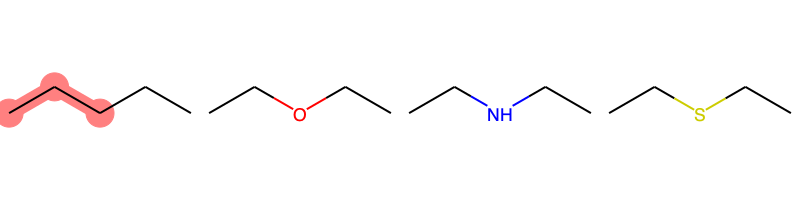

In [69]:
MolsToGridImage(mols=mol_list, molsPerRow=4, highlightAtomLists=match_list)

* The star character can be used to match any atom

In [70]:
query = Chem.MolFromSmarts('C*C')
match_list = [mol.GetSubstructMatch(query) for mol in mol_list]

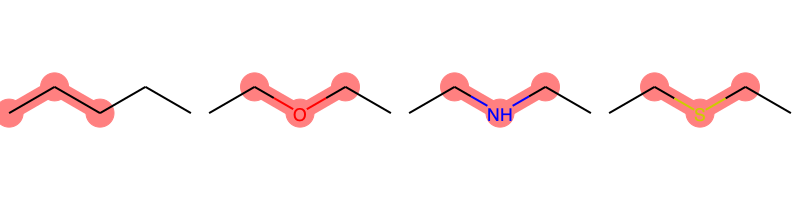

In [71]:
MolsToGridImage(mols=mol_list, molsPerRow=4, highlightAtomLists=match_list)

* The SMART syntax can be extended to only allow specific sets of atoms. For instance, the string **C[C,O,N]C** will match carbon attached to carbon, oxygen, or nitrogen, attached to another carbon. 

In [72]:
query = Chem.MolFromSmarts('C[C,O,N]C')
match_list = [mol.GetSubstructMatch(query) for mol in mol_list]

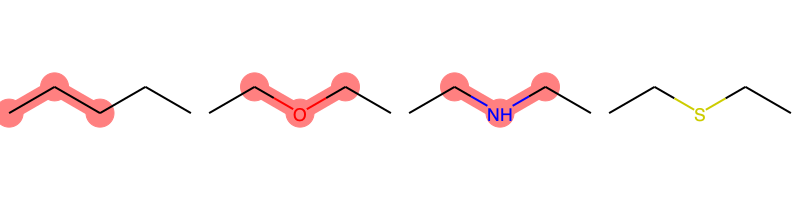

In [73]:
MolsToGridImage(mols=mol_list, molsPerRow=4, highlightAtomLists=match_list)